In [1]:
%matplotlib inline
import fceulib
from fceulib import VectorBytes
import numpy as np
import time
import matplotlib.pyplot as plt
from fceu_help import *
from math import *
import pickle

In [2]:
# Needed for Joe's pyenv to find CV2
import site
site.addsitedir("/usr/local/lib/python2.7/site-packages")

In [3]:

START = 0x08
RUN = 0x02
JUMP = 0x01

#inputVec = fceulib.readInputs('videos/algar-batman.fm2')
#emu = fceulib.runGame('batman.nes')




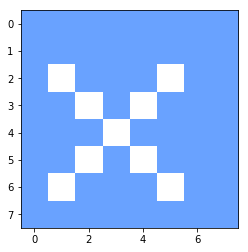

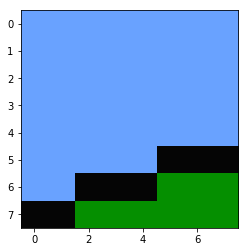

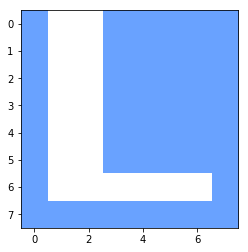

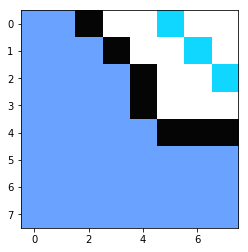

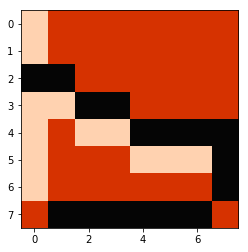

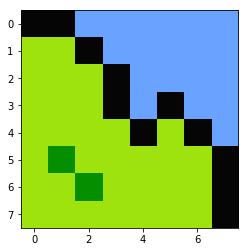

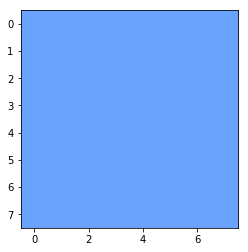

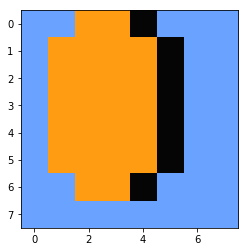

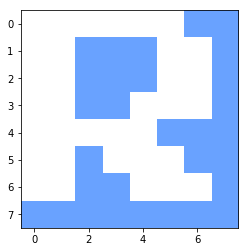

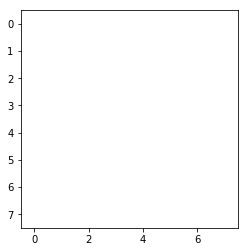

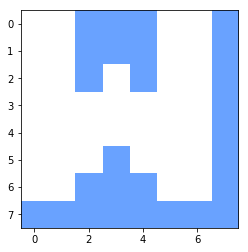

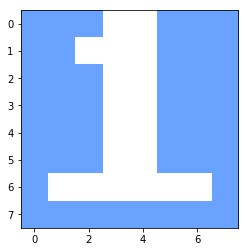

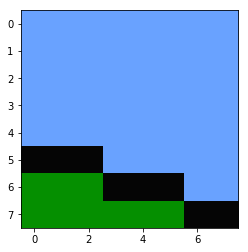

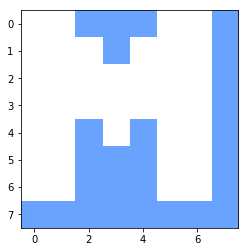

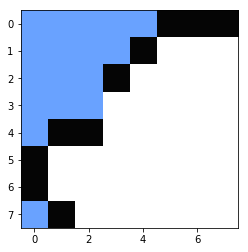

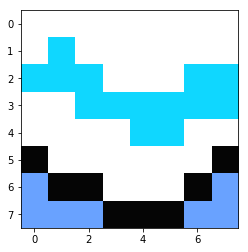

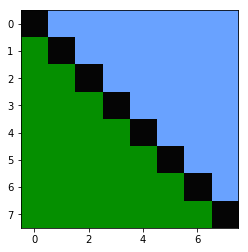

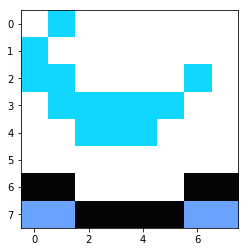

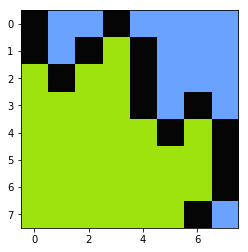

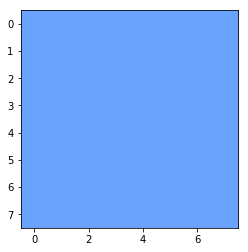

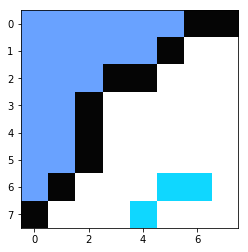

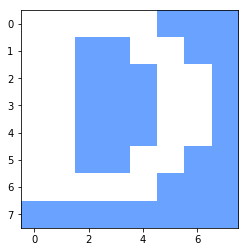

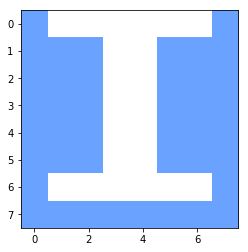

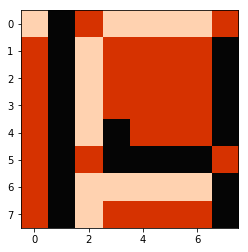

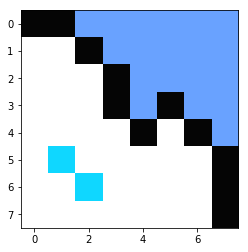

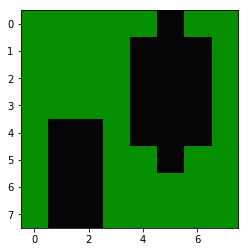

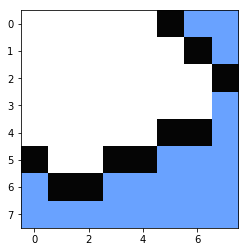

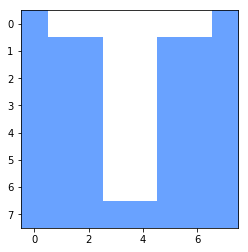

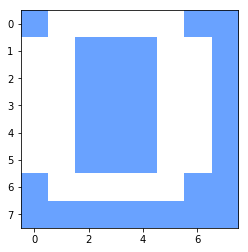

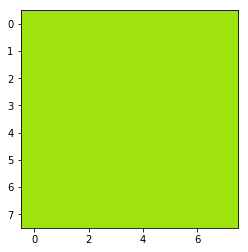

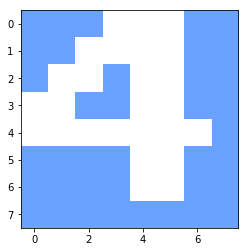

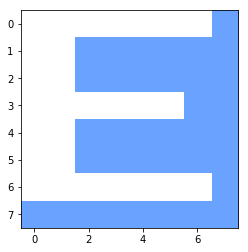

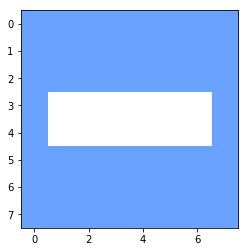

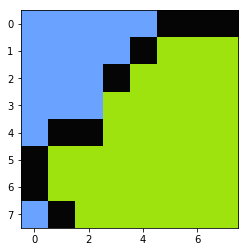

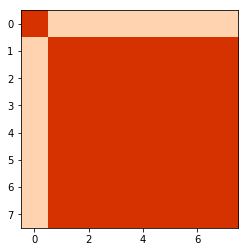

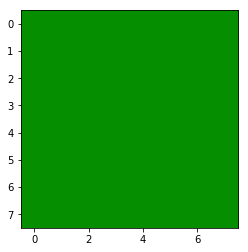

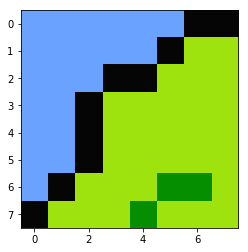

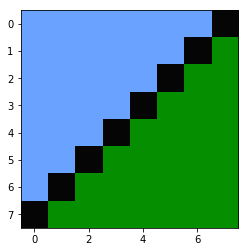

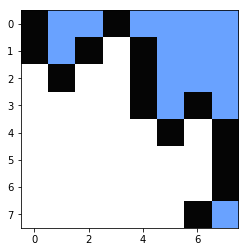

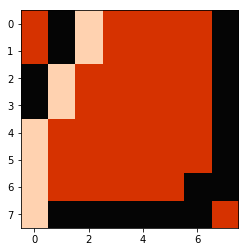

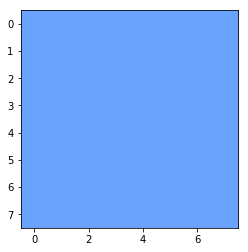

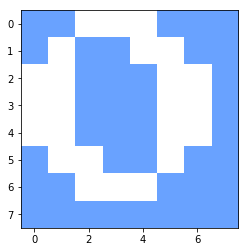

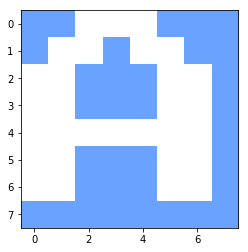

In [4]:
import cv2 
from scipy import stats
from PIL import Image
inputVec = fceulib.readInputs('Illustrative.fm2') #'videos/happylee4-smb-warpless.fm2')
emu = fceulib.runGame('mario.nes')

image_prefix = 'images/Illustrative'
nt_prefix = 'nametables'
#inputVec = fceulib.readInputs('videos/Contra by 3D.fm2')
#emu = fceulib.runGame('contra.nes')

start = VectorBytes()
emu.save(start)


peekevery = 1
emu.load(start)
display = False
img_buffer = VectorBytes()
prev = VectorBytes()

start = 270
end = float('inf')
colorized2id = {}
id2colorized = {}
tile2colorized = {}
outfile = open('Illustrative.txt','wb')
nametables = {}
nametables2 = {}
xScrolls = None
motion = {}
tnametables = {}
for timestep, inp in enumerate(inputVec):
    emu.stepFull(inp,0x0)
    if not (timestep % peekevery == 0) or timestep < start:
        continue
    if timestep > end:
        break
    if timestep % 100 == 0:
        print (100*float(timestep)/float(len(inputVec)))
        
    if xScrolls is not None:
        xScrolls[timestep]  = emu.xScroll
    nt_index = pointer_to_numpy(emu.fc.ppu.values)[0]& 0x3    
    if nametables is not None:
        nt = pointer_to_numpy(emu.fc.ppu.NTARAM)
        attr = nt[(nt_index*1024+960):(nt_index*1024+1024)]
        nt = nt[(nt_index*1024):(nt_index*1024+960)]
        nt = nt.reshape(30,32)
        attr = attr.reshape(8,8)
        full_attr = np.zeros([16,16])
        for xx in range(8):
            for yy in range(8):
                val = attr[yy,xx]
                tr = (val & 0x0c) >> 2
                tl = val & 0x03
                br = (val & 0xc0 ) >> 6
                bl = (val & 0x30 ) >> 4
                full_attr[yy*2,xx*2] = tl
                full_attr[yy*2,xx*2+1] = tr
                full_attr[yy*2+1,xx*2] = bl
                full_attr[yy*2+1,xx*2+1] = br
        full_attr = full_attr[:15,:]
        full_attr = np.kron(full_attr, np.ones((2,2)))
        nametables = (nt,full_attr)
    nt_index = 1 - nt_index
    if nametables2 is not None:
        nt = pointer_to_numpy(emu.fc.ppu.NTARAM)
        attr = nt[(nt_index*1024+960):(nt_index*1024+1024)]
        nt = nt[(nt_index*1024):(nt_index*1024+960)]
        nt = nt.reshape(30,32)
        attr = attr.reshape(8,8)
        full_attr = np.zeros([16,16])
        for xx in range(8):
            for yy in range(8):
                val = attr[yy,xx]
                tr = (val & 0x0c) >> 2
                tl = val & 0x03
                br = (val & 0xc0 ) >> 6
                bl = (val & 0x30 ) >> 4
                full_attr[yy*2,xx*2] = tl
                full_attr[yy*2,xx*2+1] = tr
                full_attr[yy*2+1,xx*2] = bl
                full_attr[yy*2+1,xx*2+1] = br
        full_attr = full_attr[:15,:]
        full_attr = np.kron(full_attr, np.ones((2,2)))
        nametables2 = (nt,full_attr)
    
    xScroll = emu.fc.ppu.lastXScroll
    yScroll = emu.fc.ppu.lastYScroll
    fineXScroll = xScroll & 0x7
    coarseXScroll = xScroll >> 3
    NT = np.kron(nametables[0], np.ones((8,8)))
    NT2 = np.kron(nametables2[0], np.ones((8,8)))
    actualNT = np.zeros(NT.shape)
    actualNT[:,:(NT.shape[1]-xScroll)] = NT[:,xScroll:]
    actualNT[:,(NT.shape[1]-xScroll):] = NT2[:,:xScroll]
    
    im = Image.fromarray(actualNT).convert('RGB')
    im.save(nt_prefix + '/nametable_{}.png'.format(timestep))
    
    attr = np.kron(nametables[1], np.ones((8,8)))
    attr2 = np.kron(nametables2[1], np.ones((8,8)))

    actualattr = np.zeros(NT.shape)
    actualattr[:,:(attr.shape[1]-xScroll)] = attr[:,xScroll:]
    actualattr[:,(attr.shape[1]-xScroll):] = attr2[:,:xScroll]
    #tnametables[timestep] = (actualNT,actualattr)
    pairs = set()
    if tile2colorized:
        pt = pointer_to_numpy(emu.fc.ppu.PALRAM)
        for ii in range(actualattr.shape[0]):
            for jj in range(actualattr.shape[1]):
                pairs.add(  ( int(actualNT[ii,jj]),int(actualattr[ii,jj])))
        for pair in pairs:
            if pair not in tile2colorized:
                tile2colorized[pair] = colorize_tile(get_tile(pair[0],emu.fc),pair[1],pt)[:,:,:3]
                #Have to divide by 255 to actual display with plt.imshow
        
    im = Image.fromarray(actualattr).convert('RGB')
    im.save(nt_prefix + '/attributes_{}.png'.format(timestep))
    
    if display:
        outputImage(emu, '{}_{}'.format(image_prefix,timestep),img_buffer)
    sprite_list,colorized_sprites = get_all_sprites(emu.fc)  
    
    for sprite_id,sprite in enumerate(sprite_list):
        if np.sum(colorized_sprites[sprite_id].ravel()) == 0:
            continue
        uniq = tuple(colorized_sprites[sprite_id].ravel())
        if uniq not in colorized2id:
            colorized2id[uniq] = len(colorized2id)
            print len(colorized2id)
            id2colorized[colorized2id[uniq]] = colorized_sprites[sprite_id]
        outfile.write('{},{},{},{}\n'.format(timestep,colorized2id[uniq],sprite[0],sprite[1]))

outfile.close()
if id2colorized:
    pickle.dump((colorized2id,id2colorized),open('id2sprites.pkl','wb'))
if tile2colorized:
    pickle.dump(tile2colorized,open('tile2colorized.pkl','wb'))

In [5]:


#uses normalized pmi as a thresholding mechanism 
# -1 = no co-occurences, 
# 0 = independent 
# 1 = only co-occur
def getFusedPairs(filename,fc,threshold=0.1):
    #Read in data
    with open(filename) as infile:
        data = []
        for line in infile:
            data.append([int(float(d)) for d in line.rstrip().split(',')])
    #get the per timestep data, as well as total counts for each sprite
    timesteps = {}
    pSprite = {}
    for d in data:
        if d[0] not in timesteps:
            timesteps[d[0]] = []
        timesteps[d[0]].append(d[1:])
        if d[1] not in pSprite:
            pSprite[d[1]] = 0
        pSprite[d[1]] += 1
    spr = get_sprite(0,emu.fc)
    height = spr.shape[0]
    #for each timestep look at all the sprite pairs and see how far apart they are,
    #if they are within width and height of each other, add that as a co-occurence
    
    all_sprites = {}
    for timestep in sorted(timesteps):
        dat = timesteps[timestep]
        for ii in range(len(dat)):
            for jj in range(len(dat)):
                if ii != jj:
                    id1 = dat[ii][0]
                    id2 = dat[jj][0]
                    dx = dat[ii][1]-dat[jj][1]
                    dy = dat[ii][2]-dat[jj][2]
                    
                    if abs(dx) > 8 or abs(dy) > height:
                        continue
                    if id1 not in all_sprites:
                        all_sprites[id1] = {}
                    if id2 not in all_sprites[id1]:
                        all_sprites[id1][id2] = 0
                    all_sprites[id1][id2] += 1
    
    #now we have all of the pieces and can calculate the pmi for each pair of sprites
    accepted = set()
    for sprite in all_sprites:
        total = 0
        dat = []
        px = float(pSprite[sprite])/float(len(timesteps))

        for other in all_sprites[sprite]:
            py = float(pSprite[other])/float(len(timesteps))
            pxy = float(all_sprites[sprite][other])/float(len(timesteps))
            d = log(px*py)/log(pxy)-1
            if d > threshold:
                s = sprite
                o = other
                if sprite > other:
                    o = sprite
                    s = other
                accepted.add((s,o))
    return accepted
getFusedPairs('Illustrative.txt',emu.fc)

set()

In [6]:
help(fceulib)

Help on module fceulib:

NAME
    fceulib - Python wrapper for fceulib NES emulation

FILE
    /home/darkacloo/mechlearn/mechlearn/fceulib.so

CLASSES
    __builtin__.object
        BytePointer
        Cart
        Emulator
        FC
        FCEU
        PPU
        VectorBytes
        VectorShorts
    
    class BytePointer(__builtin__.object)
     |  Methods defined here:
     |  
     |  __getitem__(...)
     |      __getitem__(self: fceulib.BytePointer, arg0: int) -> int
     |  
     |  __init__(...)
     |      x.__init__(...) initializes x; see help(type(x)) for signature
     |  
     |  __len__(...)
     |      __len__(self: fceulib.BytePointer) -> int
     |  
     |  __setitem__(...)
     |      __setitem__(self: fceulib.BytePointer, arg0: int, arg1: float) -> None
     |  
     |  ----------------------------------------------------------------------
     |  Data and other attributes defined here:
     |  
     |  __new__ = <built-in method __new__ of type object>
     |  

In [7]:
pickle.dump(motion,open('Illustrative_screen_motion.pkl','wb'))